<a href="https://colab.research.google.com/github/nguyengiapphuongduy/ml-191/blob/master/linear_discriminant_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class LDA

$$\begin{align*}
m_k &= \frac{1}{N_k}\sum_{n \in \mathcal{C}_k} x_n, \\
m &= \frac{1}{N}\sum_{n=1}^{N} x_n, \\
S_B &= \sum_{k=1}^{C} N_k (m_k-m)(m_k-m)^T,\\
S_W &= \sum_{k=1}^{C} \sum_{n \in \mathcal{C}_k} (x_n-m_k)(x_n-m_k)^T\\\\
A &= S_W^{-1}S_B = USV^T
\end{align*}$$


In [0]:
class MyLDA():
    def __init__(self, n_components=1):
        self.n_components = n_components

    def fit(self, X, y):
        N = X.shape[0]
        self.xbar_ = X.mean(axis=0)
        classes = np.unique(y)
        # within class scatter matrix and class-mean vectors
        SW, mk = 0, []
        for c in classes:
            # get class elements
            XC = X[y==c]
            # get means and shift to zero
            mk += [XC.mean(axis=0)]
            XC -= mk[-1]
            # update mk to calculate the between-class scatter matrix
            mk[-1] = (mk[-1] - self.xbar_)*XC.shape[0]
            SW += XC.T.dot(XC) # within-class scatter
        mk = np.asarray(mk)
        SB = mk.T.dot(mk) # between-class scatter
        target = np.linalg.inv(SW).dot(SB)
        U, S, VT = np.linalg.svd(target)
        self.scalings_ = VT[:self.n_components].T

    def transform(self, X):
        return (X - self.xbar_).dot(self.scalings_)

    def inverse_transform(self, Xu):
        return Xu.dot(self.scalings_) + self.xbar_

# Apply

### Generate Input

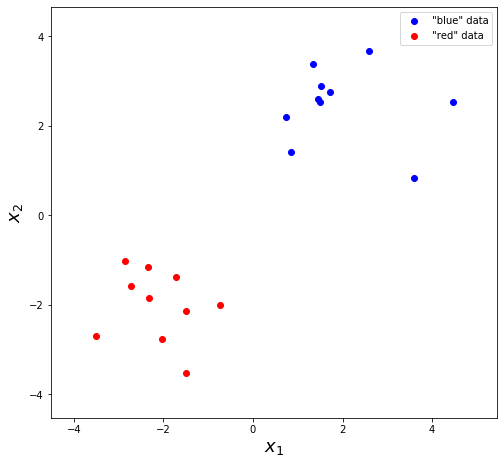

In [0]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

N1, N2 = 10, 10
X1 = np.random.multivariate_normal([-2, -2], [[1, 0], [0, 2]], N1)
X2 = np.random.multivariate_normal([2, 2], [[2, 0], [0, 1]], N2)
X = np.concatenate((X1, X2))
y = np.concatenate((-np.ones(len(X1)), np.ones(len(X2))))

plt.figure(figsize=(8, 8))
plt.axes().set_aspect('equal')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
xmin, ymin = X.min(axis=0) - 1
xmax, ymax = X.max(axis=0) + 1
plt.axis((xmin, xmax, ymin, ymax))
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='"blue" data')
plt.scatter(X[y!=1, 0], X[y!=1, 1], color='red', label='"red" data')
plt.legend()
pass

### Fit

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

skLDA = LDA(n_components=1, solver='svd')
skLDA.fit(X, y)

myLDA = MyLDA(n_components=1)
myLDA.fit(X, y)

### Compare results

In [0]:
def compare(vec1, vec2):
    '''check if two vectors are have the same direction'''
    div = vec1/vec2
    return np.allclose(div, div[0])

sklda = skLDA.scalings_
mylda = myLDA.scalings_
print('sklearn LDA:', sklda, 'my implement:', mylda,
      'My LDA == sklearn: {}'.format(compare(mylda, sklda)), sep='\n')

sklearn LDA:
[[0.65583546]
 [1.03143344]]
my implement:
[[-0.67424909]
 [-0.738504  ]]
My LDA == sklearn: False


In [0]:
sklda = skLDA.transform(X)
mylda = myLDA.transform(X)
print('sklearn LDA:', sklda, 'my implement:', mylda,
      'My LDA == sklearn: {}'.format(compare(mylda, sklda)), sep='\n')

sklearn LDA:
[[-2.92528852]
 [-4.803326  ]
 [-2.73401742]
 [-4.39048273]
 [-2.75524642]
 [-3.11690324]
 [-3.59418734]
 [-3.38643722]
 [-5.27755953]
 [-3.61656221]
 [ 3.79107302]
 [ 1.82311602]
 [ 3.42536901]
 [ 5.35232856]
 [ 2.54993382]
 [ 4.18812963]
 [ 5.27867742]
 [ 3.3911124 ]
 [ 3.78864183]
 [ 3.01162892]]
my implement:
[[ 2.55951499]
 [ 3.72901689]
 [ 2.09425337]
 [ 3.54634393]
 [ 2.31162292]
 [ 2.799483  ]
 [ 3.11412076]
 [ 2.71536446]
 [ 4.48233107]
 [ 3.04879529]
 [-3.03968474]
 [-1.49433947]
 [-2.76404482]
 [-4.75994258]
 [-1.99119397]
 [-3.29029625]
 [-4.32367413]
 [-2.74977661]
 [-3.08110031]
 [-2.90679379]]
My LDA == sklearn: False


### Plot

sklearn LDA:
[[0.65583546]
 [1.03143344]]
my implement:
[[-0.67424909]
 [-0.738504  ]]


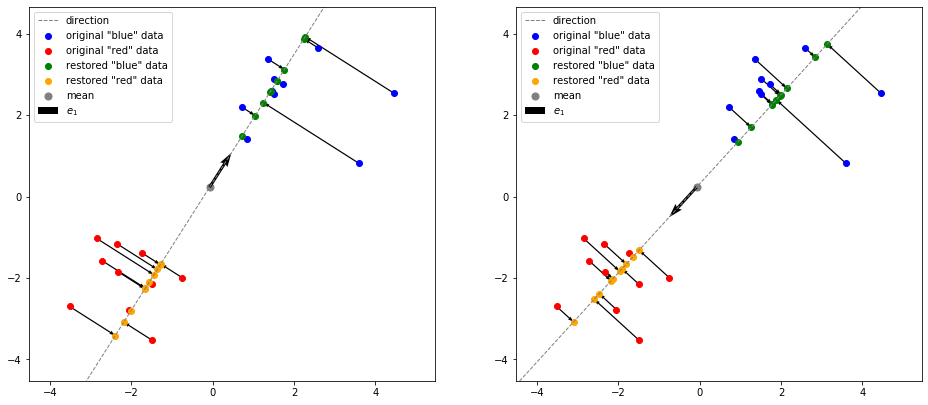

In [0]:
def plot_(ax, lda):
    direct = lda.scalings_.T
    direct /= np.linalg.norm(direct, ord=2)
    center = lda.xbar_
    Xnew = lda.transform(X).dot(direct) + lda.xbar_
    direct = direct[0]

    ax.set_aspect('equal')
    xmin, ymin = X.min(axis=0) - 1
    xmax, ymax = X.max(axis=0) + 1
    ax.axis((xmin, xmax, ymin, ymax))

    x_plot = np.linspace(xmin, xmax, 100) # b(x-x0) - a(y-y0)=0
    y_plot = direct[1]/direct[0]*(x_plot - center[0]) + center[1]
    ax.plot(x_plot, y_plot, '--', color='gray', linewidth=1, label='direction')
    ax.quiver(X[:, 0], X[:, 1], Xnew[:, 0] - X[:, 0], Xnew[:, 1] - X[:, 1],
              scale_units='xy', scale=1, color='black', width=0.003)
    ax.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='original "blue" data')
    ax.scatter(X[y!=1, 0], X[y!=1, 1], color='red', label='original "red" data')
    ax.scatter(Xnew[y==1, 0], Xnew[y==1, 1], color='green', label='restored "blue" data')
    ax.scatter(Xnew[y!=1, 0], Xnew[y!=1, 1], color='orange', label='restored "red" data')
    ax.scatter(center[0], center[1], color='gray', s=[50], label='mean')
    ax.quiver(center[0], center[1], direct[0], direct[1],
              scale_units='xy', scale=1, color='black', width=0.007, label='$e_1$')
    ax.legend()
    pass

sklda = skLDA.scalings_
mylda = myLDA.scalings_
print('sklearn LDA:', sklda, 'my implement:', mylda, sep='\n')

fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
plot_(ax[0], skLDA)
plot_(ax[1], myLDA)